#Imports и поверхностный анализ

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/drive')
path = "/drive/MyDrive/DS/Spam_classification"

!mkdir data
!cp -a /$path/. data

Mounted at /drive


In [3]:
train_part = pd.read_csv('data/train_spam.csv')
train_part.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Типы значений:

In [4]:
train_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


Посмторим на количество сообщений, попадающих в спам, и нормальных:

In [5]:
train_part['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

Посмотрим на всякий случай, есть ли Nan-ы:

In [6]:
train_part.isnull().any()

text_type    False
text         False
dtype: bool

# Анализ сообщений и его предобработка для первого подхода(см в разделе про модели)

Закодируем target. Если спам, то 1, и 0 в противном случае соответственно.

In [21]:
train_part['text_type'] = train_part['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

train_part.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


Уберем вначале все лишние табуляции:

In [ ]:
clean_data = train_part.copy()

clean_data['text'] = clean_data['text'].apply(lambda x: x.replace('\\n',' ').replace("\t",' ').replace('\\',' '))

Уберем стоп слова за некоторым исключением:

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopword_list = stopwords.words("english")
stopword_list.remove('no')
stopword_list.remove('nor')
stopword_list.remove('not')

def clean_stopwords(text):
    tokens = word_tokenize(text)
    clean_text = [word.lower() for word in tokens if not (word.lower() in stopword_list) and (len(word) > 2)]
    return clean_text

clean_data['text'] = clean_data['text'].apply(clean_stopwords)

Также чтобы посмотреть, какие слова встречаются чаще всего, используем лемматизацию:

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def text_lemm(text):
    lemm_text = []
    for word in text:
        lemm_text.append(lemmatizer.lemmatize(word))
    return lemm_text

clean_data['text'] = clean_data['text'].apply(text_lemm)

Псотрим на текст сообщений теперь:

In [ ]:
clean_data.head()

,text_type,text
0,0,"[make, sure, alex, know, birthday, fifteen, mi..."
1,0,"[resume, john, lavorato, thanks, vince, get, m..."
2,1,"[plzz, visit, website, moviesgodml, get, movie..."
3,1,"[urgent, mobile, number, awarded, £2000, prize..."
4,0,"[overview, associate, analyst, project, per, d..."


Выведем топ 15 самых частых слов в текстах:

In [ ]:
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize,sent_tokenize

counnter_words = Counter()

def count_words(words):
    for word in words:
        counnter_words.update({word: 1})

clean_data['text'].apply(count_words)

counnter_words.most_common(15)

[('1635465', 12568),
 ('ect', 5349),
 ('enron', 4848),
 ('vince', 4526),
 ('url', 3924),
 ('not', 3334),
 ('hou', 2663),
 ('kaminski', 2365),
 ('please', 2352),
 ('com', 2331),
 ('get', 2288),
 ('2000', 2253),
 ('subject', 2203),
 ('would', 2036),
 ('time', 2033)]

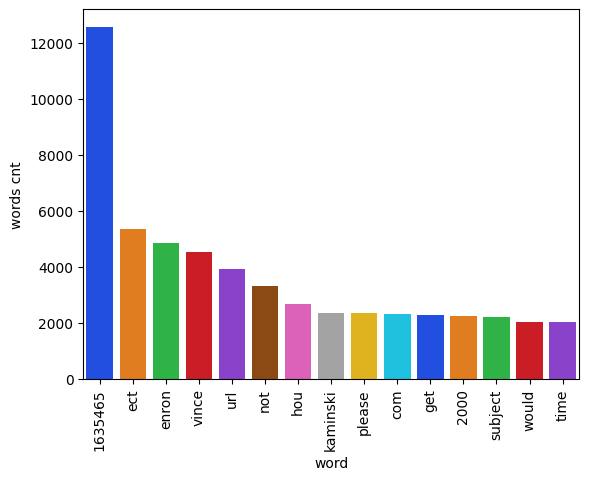

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")

df=pd.DataFrame(counnter_words.most_common(15), columns=['word', 'words cnt'])

sns.barplot(x=df["word"],y=df["words cnt"], palette='bright')
plt.xticks(rotation=90)
plt.show()

Можно заметить, что в тексте встречаются очень странные слова. Так топ 1 - номер 1635465. Также в топ еще попало число 2000. Так же видно, что часто встречаются всякие служебные слова по типу com(вероятно ссылки на сайты).

Теперь посмотрим на самые частые слова в спам текстах:

In [ ]:
counnter_words = Counter()

clean_data[clean_data['text_type'] == 1]['text'].apply(count_words)

counnter_words.most_common(15)

[('1635465', 1568),
 ('free', 1059),
 ('get', 871),
 ('not', 777),
 ('call', 566),
 ('click', 555),
 ('new', 550),
 ('link', 524),
 ('one', 495),
 ('offer', 484),
 ('account', 480),
 ('com', 479),
 ('company', 472),
 ('money', 471),
 ('time', 465)]

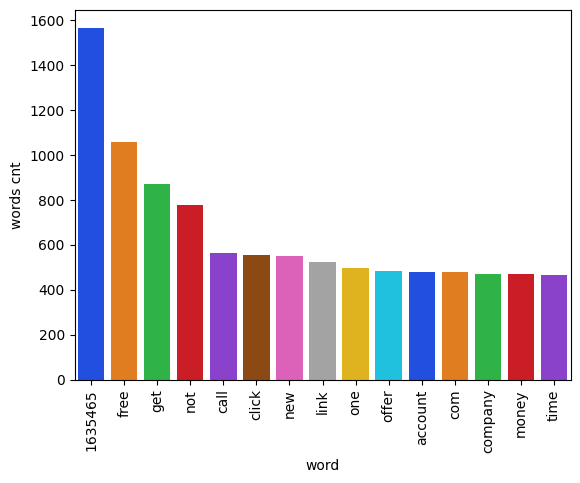

In [ ]:
df=pd.DataFrame(counnter_words.most_common(15), columns=['word', 'words cnt'])

sns.barplot(x=df["word"],y=df["words cnt"], palette='bright')
plt.xticks(rotation=90)
plt.show()

Видно, что многие слова остались такими же. Но появились слова наподобие click, link, offer, free. Эти слова обычно и употребляются в спам рассылках. Также интересно, что число 1635465 встречается всего 1568 раз из 12568. Но пропорция спама и не спама другая. То есть можно сделать вывод, что это слово, в среднем, чаще появляется в нормальных сообщениях.

Теперь в нормальных текстах:

In [ ]:
counnter_words = Counter()

clean_data[clean_data['text_type'] == 0]['text'].apply(count_words)

counnter_words.most_common(15)

[('1635465', 11000),
 ('ect', 5344),
 ('enron', 4848),
 ('vince', 4525),
 ('url', 3624),
 ('hou', 2660),
 ('not', 2557),
 ('kaminski', 2365),
 ('2000', 2204),
 ('subject', 2114),
 ('please', 1888),
 ('com', 1852),
 ('would', 1849),
 ('time', 1568),
 ('like', 1440)]

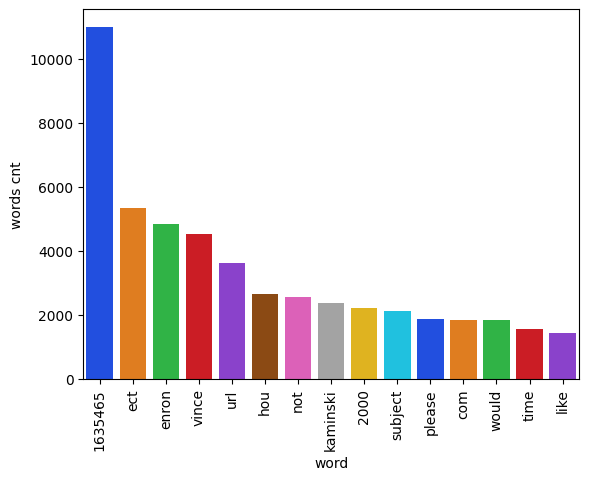

In [ ]:
df=pd.DataFrame(counnter_words.most_common(15), columns=['word', 'words cnt'])

sns.barplot(x=df["word"],y=df["words cnt"], palette='bright')
plt.xticks(rotation=90)
plt.show()

Здесь слова не такие же, как и при сравнении по всему датасету.

Таким образом, для спам сообщений присутствуют некоторые характерные слова по типу: click, link, offer, free. То есть возможно постороить не только смысловой классификатор, но и просто ориентирующийся на некоторые слова. Также важно отметить, что датасет слегка странный. В нем слово топ 1 по встречаемости это номер. Также в некоторых сообщениях встречается очень много эмодзи. Поэтому результаты могут получиться не самые хорошие.

# Модели

Попробуем несколько подходов для решения задачи:

1) С помощью предобработки текста, которая проводилась в анализе сообщений, и CountVectorizer получим для каждого текста вектор(каждый эелемент - число повторений определенного слова в нем). Далее обучим классификаторы на этом входе.

2) Будем классифицировать эмбэддинги, полученные моделями, которые учитывают контекст. Дальше будем классифицировать эти эмбеддинги.

## Первый подход

Вначале построим новый датафрейм, где для каждого слова в тексте будет указана его частота встречаемости:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(analyzer=lambda x: x)

bow = count_vec.fit_transform(clean_data['text']).toarray()

new_data = pd.DataFrame(bow, columns=count_vec.get_feature_names_out())
new_data.head()

,+1201,+12139806811,+12292342098,+447441465743,+447706669718,+600,+800uc,+91,+mkv,-30,...,🥺🥺🥺,🦾its,🧑🏻‍💻,🧧🧧all,🧧🧧🧧🧧🧧🧧,🧨🧨🎃🎃,🧬ɴᴀᴛᴜʀᴇ,🧭now,🪄🪄🪄🪄🪄🪄🪄🪄🪄,🪙🪙🪙🪙🪙🪙🪙🪙
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Заметим, что сюда попали номера и эмодзи. Есть предположение, что они тоже могут показывать спам, так как в обычной переписке люди не используют столько эмодзи.

Разделим данные на train и test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data, clean_data['text_type'], test_size=0.2, stratify=clean_data['text_type'])

print('Train size: ', len(X_train))
print('Test size: ', len(X_test))

Train size:  13022
Test size:  3256


### Байесовская классификация.

Так как при анализе мы выяыили слова, которые встречаются чаще всего в спаме, то имеет смысл попробовать Байесовскую классификацию.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train, y_train)

MultinomialNB()

Получим предсказания:

In [ ]:
y_pred = mnb.predict(X_test)

Постчитаем дополнительные к ROC AUC:

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_classification_score(y_true, y_pred):
    print("Accuracy: ",  accuracy_score(y_true, y_pred))
    print("Recall metric: ",  recall_score(y_true, y_pred, average='binary'))
    print("F1 Score: ", f1_score(y_true, y_pred, average='binary'))

In [ ]:
print_classification_score(y_test, y_pred)

Accuracy:  0.9164619164619164
Recall metric:  0.9345114345114345
F1 Score:  0.8685990338164251


Посчитаем ROC AUC. Для этого для каждого объекта вернем вероятность(predict_proba(X)).

In [ ]:
from sklearn.metrics import roc_auc_score

y_pob = mnb.predict_proba(X_test)[:, 1]
print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.972584632785156


### Логистическая регрессия

Далее не будем выводить время обучения, так как на GPU оно все равно очень маленькое.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train[:6000], y_train[:6000])

LogisticRegression()

Посчитаем метрики:

In [ ]:
y_pred = clf.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9284398034398035
Recall metric:  0.817047817047817
F1 Score:  0.8709141274238228


Выведем ROC AUC:

In [ ]:
y_pob = clf.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9719375501851526


### SVM

In [ ]:
from sklearn import svm

C_value = 0.1
svc = svm.SVC(C=C_value, kernel='linear', random_state=42, probability=True)

svc.fit(X_train, y_train)

Получим предсказания:

In [ ]:
y_pred = svc.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9175398636398236
Recall metric:  0.907057312048317
F1 Score:  0.8718151773938928


Посчитаем ROC AUC:

In [ ]:
y_pob = svc.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9701355708391936


### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100)

xgb.fit(X_train[:3600], y_train[:3600])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Получим предсказания:

In [ ]:
y_pred = xgb.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.8986486486486487
Recall metric:  0.7515592515592515
F1 Score:  0.8141891891891891


Выведем ROC AUC:

In [ ]:
y_pob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9536542947615311


### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier()

cls.fit(X_train, y_train)

RandomForestClassifier()

Метрики в этом подходе:

In [ ]:
y_pred = cls.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9093980343980343
Recall metric:  0.7203742203742204
F1 Score:  0.8245092207019631


ROC AUC на тестовом наборе:

In [ ]:
y_pob = cls.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9710620854910305


Результаты этого подхода:

| model_name    | MultinomialNB | LogisticRegression | SVM    | XGBClassifier | Random Forest Classifier |
|---------------|---------------|--------------------|--------|---------------|--------------------------|
| ROC AUC score | 0.9726        | 0.9719             | 0.9701 | 0.9537        | 0.9711                  |

Видно, что XGB справился со своей задачей лучше всех. При это Байесовский классификатор показывает значение метрики не сильно хуже(разница в 0.0011). То есть в данном случае характерные для спама слова помогают работе Байесовского классификатора.

## Второй подход

В качестве контекстной модели возьмем BERT. Признаки будем доставать двумя способами:

1) Возьмем последние 4 hidden layers и усредним их значения.

2) Возьмем последний слой(pooler).

### First Feature Extractor

In [7]:
from transformers import BertModel, BertTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
def extract_features(text):
    input_ids = torch.tensor([tokenizer.encode(text, padding=True, truncation=True,max_length=50, add_special_tokens = True)]).to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]

    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])

    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    return torch.stack(features).cpu()

Достанем признаки:

In [23]:
import datetime

features = []

start = datetime.datetime.now()
for i in range(len(train_part)):
    features.append(extract_features(train_part.iloc[i]["text"]))
print("Time passed: " + str(datetime.datetime.now()-start))

features = torch.cat(features).numpy()

Time passed: 0:03:30.258595


Сохраним их на всякий случай:

In [ ]:
np.save("text_bert_features.npy", features)

Посмотрим на размер target-а и пирзнаков:

In [24]:
labels = train_part['text_type'].values

features.shape, labels.shape

((65112, 768), (16278,))

Изменим размеры, чтобы их длина была одинаковая:

In [25]:
features_reshaped = features.reshape((len(train_part), -1))

data = np.hstack((features_reshaped, labels.reshape((-1, 1))))

Разделим датасет на 2 части(чтобы был один и тот же словарь, это надо делать после извлечения эмбеддингов).

In [26]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

In [27]:
print("Train data size: ", len(X_train))
print("Test data size: ", len(X_test))

Train data size:  13022
Test data size:  3256


Теперь классифицируем эти эмбеддинги и сравним значения метрики на разных классификаторах(Байесовский здесь использовать не получится, а остальные оставим).

#### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_classification_score(y_true, y_pred):
    print("Accuracy: ",  accuracy_score(y_true, y_pred))
    print("Recall metric: ",  recall_score(y_true, y_pred, average='binary'))
    print("F1 Score: ", f1_score(y_true, y_pred, average='binary'))

In [ ]:
print_classification_score(y_test, y_pred)

Accuracy:  0.9505528255528255
Recall metric:  0.9090909090909091
F1 Score:  0.9134873723804406


In [ ]:
from sklearn.metrics import roc_auc_score

y_pob = clf.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9855760125522145


#### SVM


In [ ]:
from sklearn import svm

C_value = 0.1
svc = svm.SVC(C=C_value, kernel='linear', random_state=42, probability=True)

svc.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [ ]:
y_pred = svc.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.949017199017199
Recall metric:  0.9048128342245989
F1 Score:  0.9106566200215285


In [ ]:
y_pob = svc.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9845922027892274


#### XGBoost

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100)

In [28]:
start = datetime.datetime.now()
xgb.fit(X_train, y_train)
print("Time passed: " + str(datetime.datetime.now()-start))

Time passed: 0:01:48.235215


In [ ]:
y_pred = xgb.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9502457002457002
Recall metric:  0.8877005347593583
F1 Score:  0.9110867178924259


In [ ]:
y_pob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9876772643176576


#### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier()

In [ ]:
start = datetime.datetime.now()
cls.fit(X_train, y_train)
print("Time passed: " + str(datetime.datetime.now()-start))

Time passed: 0:01:35.734578


In [ ]:
y_pred = cls.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9296683046683046
Recall metric:  0.7967914438502673
F1 Score:  0.866783013379872


In [ ]:
y_pob = cls.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9803302559518187


Результаты этого подхода:

| model_name    | LogisticRegression | SVM    | XGBClassifier | Random Forest Classifier |
|---------------|--------------------|--------|---------------|--------------------------|
| ROC AUC score | 0.9856             | 0.9846 | 0.9877        | 0.9803                   |

В целом, с использованием эмбеддингов, которые извлекаются, используя контекстную модель, классификация получается точнее. Причем метрики на разных классификаторах отличаются не так сильно.

### Second Feature Extractor

Выведем устройство модели. Видно, что последний слой - pooler. Попробуем подавать для классификации только его.

In [53]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Вытащим признаки:

In [54]:
def extract_features_pooler(text):
    text = text.lower()
    input_ids = torch.tensor([tokenizer.encode(text, padding=True, truncation=True,max_length=50, add_special_tokens = True)]).to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs['pooler_output']

    return hidden_states.cpu()

In [55]:
features = []

start = datetime.datetime.now()
for i in range(len(train_part)):
    features.append(extract_features_pooler(train_part.iloc[i]["text"]))
print("Time passed: " + str(datetime.datetime.now()-start))

features = torch.cat(features).numpy()

Time passed: 0:03:20.776068


Сохраним полученные эмбеддинги:

In [ ]:
np.save("text_bert_features_pooler.npy", features)

Размеры признаков и target-а в данном случае одинаковые:

In [56]:
labels = train_part['text_type'].values

features.shape, labels.shape

((16278, 768), (16278,))

Разделим датасет на train и test:

In [57]:
data = np.hstack((features, labels.reshape((-1, 1))))

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

In [58]:
print("Train data size: ", len(X_train))
print("Test data size: ", len(X_test))

Train data size:  13022
Test data size:  3256


Посмотрим на получившиеся значения метрик:

#### XGBoost

Протестируем вначале на XGBoost, так как он дает результаты лучше на эмбеддингах(смотри выше).

In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100)

Обучим модель:

In [60]:
start = datetime.datetime.now()
xgb.fit(X_train, y_train)
print("Time passed: " + str(datetime.datetime.now()-start))

Time passed: 0:00:27.936350


Получим предсказания и метрики:

In [63]:
y_pred = xgb.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9195331695331695
Recall metric:  0.8085561497326204
F1 Score:  0.8523111612175874


ROC AUC метрика:

In [65]:
y_pob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.967366546320851


#### Логистическая регрессия

In [68]:
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Получим предсказания, используя для классификации логистическую регрессию:

In [69]:
y_pred = clf.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9342751842751843
Recall metric:  0.8652406417112299
F1 Score:  0.8831877729257642


ROC AUC метрика:

In [71]:
y_pob = clf.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9734122531547577


#### SVM

In [74]:
C_value = 0.1
svc = svm.SVC(C=C_value, kernel='linear', random_state=42, probability=True)

svc.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

Получим предсказания и метрики:

In [75]:
y_pred = svc.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.9315110565110565
Recall metric:  0.8481283422459893
F1 Score:  0.8767274737423992


ROC AUC score:

In [76]:
y_pob = svc.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9703831789266567


#### RandomForest

In [79]:
cls = RandomForestClassifier()

cls.fit(X_train, y_train)

RandomForestClassifier()

Получим предсказания также для случайного леса:

In [80]:
y_pred = cls.predict(X_test)

print_classification_score(y_test, y_pred)

Accuracy:  0.875
Recall metric:  0.627807486631016
F1 Score:  0.7425679949399114


И получим значение метрики ROC AUC на нем:

In [81]:
y_pob = cls.predict_proba(X_test)[:, 1]

print("ROC AUC score: ", roc_auc_score(y_test, y_pob, average=None))

ROC AUC score:  0.9415865833231574


Результаты работы:

| model_name    | LogisticRegression | SVM    | XGBClassifier | Random Forest Classifier |
|---------------|--------------------|--------|---------------|--------------------------|
| ROC AUC score | 0.9734             | 0.9704 | 0.9674        | 0.9415                   |

Заметим, что на таких векторах модели работают хуже. Также стоит отметить, что в данном случае лучший результат дает логистическая регрессия. А XGBoost работает хуже.

# Теперь предскажем значения для тестового файла:

In [29]:
test = pd.read_csv('data/test_spam.csv')
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


Извлечем эмбеддинги, используя ту же модель:

In [30]:
import datetime

features_test = []

start = datetime.datetime.now()
for i in range(len(test)):
    features_test.append(extract_features(test.iloc[i]["text"]))
print("Time passed: " + str(datetime.datetime.now()-start))

features_test = torch.cat(features_test).numpy()

Time passed: 0:00:56.209210


Подкорректируем признаки для предсказания:

In [32]:
features_reshaped = features_test.reshape((len(test), -1))
features_reshaped.shape

(4070, 3072)

Предскажем для каждого predict_proba. То есть по сути вероятность принадлежности письма к спаму. Так как у спама traget=1.

In [50]:
y_prob = xgb.predict_proba(features_reshaped)[:, 1]
len(y_prob)

4070

Добавим в датафрейм:

In [51]:
test['score'] = y_prob.tolist()
test.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.000090
1,original message from bitbitch magnesium net p...,0.135144
2,java for managers vince durasoft who just taug...,0.002002
3,there is a youtuber name saiman says,0.000073
4,underpriced issue with high return on equity t...,0.994698


Сохраним csv файл:

In [52]:
test.to_csv('test.csv', index=False)

Опробовав разные подходы и классификаторы, можно скзаать что подход с извлечением признаков с помощью BERT и последующей классификацией с использованием XGBoost дает лучший по ROC AUC результат. Но в целом и все остальные подходы отстают не очень сильно.